# VIDUS chr23 GWAS
__Author__: Jesse Marks <br>
**Date**: September 20, 2018 <br>
**GitHub**: [Issue #98](https://github.com/RTIInternational/bioinformatics/issues/98#) <br>

This document logs the steps taken to perform GWAS for HIV Acquisition on chrX of the dataset [VIDUS](https://www.bccsu.ca/vidus/). The starting point for this analysis is after quality control of observed genotypes and subsequently imputed on the Michigan Imputation Server. The quality controlled genotypes are oriented on the GRCh37 plus strand. 

## Software and tools
The software and tools used for porcessing these data are
* [Michigan Imputation Server](https://imputationserver.sph.umich.edu/index.html) (MIS)
* [Amazon Web Services (AWS) - Cloud Computing Services](https://aws.amazon.com/)
    * Linux AMI
* [PLINK v1.90 beta 4.10](https://www.cog-genomics.org/plink/)
* [bgzip](http://www.htslib.org/doc/tabix.html)
* [BCF Tools](http://www.htslib.org/doc/bcftools.html)
* Windows 10 with [Cygwin](https://cygwin.com/) installed
* GNU bash version 4.2.46

## Data retrieval and organization

VIDUS <br>
EA: start 17565; post missingness 16472; post HWE 16471

Updated VIDUS chrX QC - new files located here: <br>
https://rti-midas-data.s3.amazonaws.com/studies/vidus/observed/final/vidus.ea.chr23.bed <br>
https://rti-midas-data.s3.amazonaws.com/studies/vidus/observed/final/vidus.ea.chr23.bim <br>
https://rti-midas-data.s3.amazonaws.com/studies/vidus/observed/final/vidus.ea.chr23.fam <br>

Imputed data located at:
s3://rti-midas-data/studies/vidus/imputed/20180921

### chrX Statistics Breakdown 
This table includes the initial number of variants in each study as well as the final number of variants in the intersection set. The `Variants Post-Filtering` is in referral to the filtering steps (1) remove discordant alleles & (2) removal of monomorphic variants.

#### EA
| Data Set      | Initial Variants (Post-QC)| Variants Post-Filtering  | Intersection     |
|---------------|---------------------------|--------------------------|------------------|
| VIDUS         |   16,471                  |  14,705                  | NA               |


 zcat chrX.no.auto_female.dose.vcf.gz | wc -l
1825784
 zcat chrX.no.auto_male.dose.vcf.gz | wc -l
1825786

Download and process phenotype data.

Note, the observed genotype data were already downloaded from: <br>
`s3://rti-midas-data.s3.amazonaws.com/studies/vidus/observed/final/`

In [ ]:
# create directory structure
data_dir=/home/ec2-user/jmarks/sandbox/001
processing_dir=/home/ec2-user/jmarks/sandbox/001
study=vidus
ancestry=ea
mkdir -p ${data_dir}/phenotype/processing 
mkdir -p ${data_dir}/genotype/{observed,imputed} 
mkdir -p ${processing_dir}/eigenstrat/results

# Download data (remove --dryrun to actually download)
aws s3 sync s3://rti-hiv/vidas_data/phenotype/ ${data_dir}/phenotype --dryrun
aws s3 sync s3://rti-midas-data/studies/vidus/imputed/20180921/ ${data_dir}/genotype/imputed/ --dryrun
# had to convert this file to unix format - it was in dos
aws s3 cp s3://rti-hiv/vidas_data/fang_processing/vidus_iid.txt ${data_dir}/phenotype # gwas_id --> iid

# Prepare Files for ProbABEL
## Phenotype

* check the distribution of phenotypes and covariates in R at local machine


  0   1 
685 253 

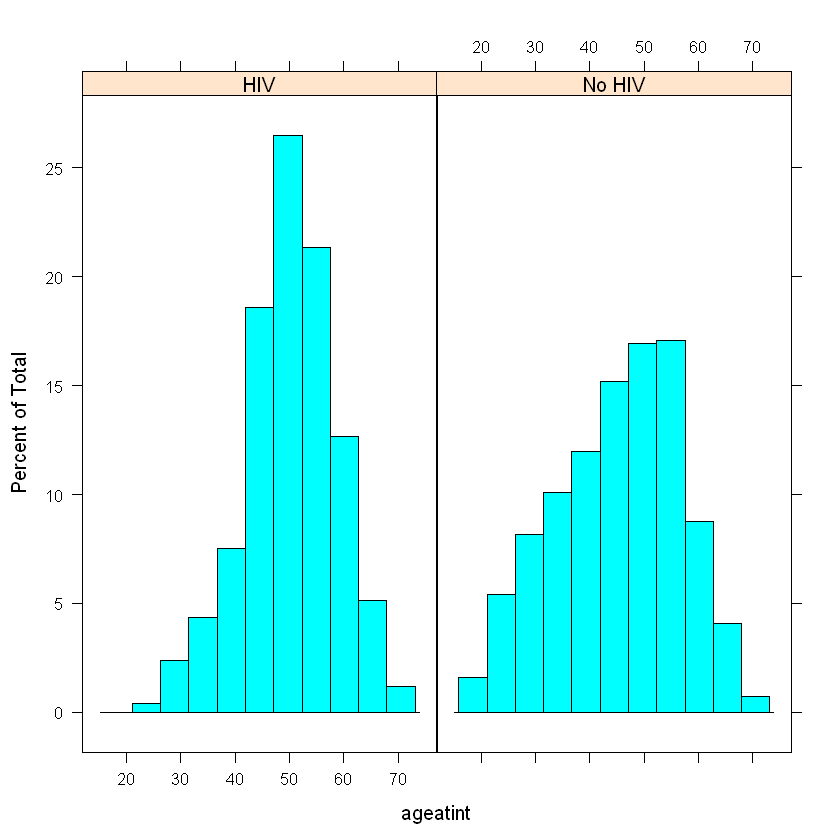

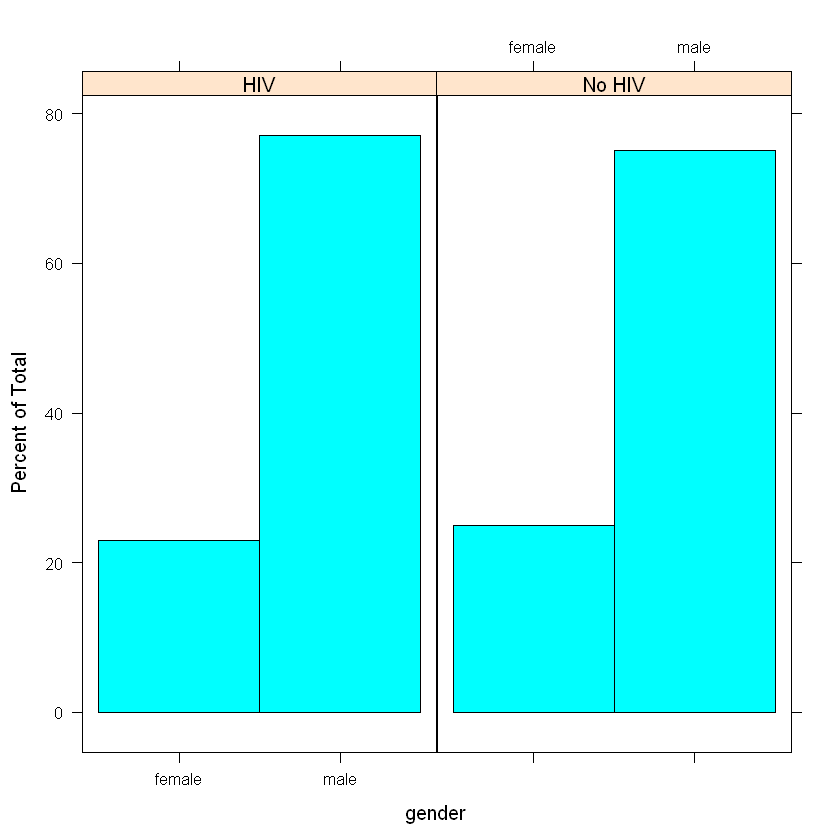

In [2]:
### R (local) ###
setwd("C:/Users/jmarks/Desktop/Projects/HIV/vidus/")
pheno <- read.csv("GWAS-Cohort-n938_passed_g_qc_only_HIV status_baseline.csv")

library(lattice)

gender <- rep("male",dim(pheno)[1])
gender[pheno$female==1] <- "female"

table(pheno$hiv)

hiv_status <- rep("No HIV", dim(pheno)[1])
hiv_status[pheno$hiv==1] <- "HIV"

histogram( ~ ageatint | hiv_status, data=cbind(pheno,hiv_status))

histogram( ~ gender | hiv_status, data=cbind(pheno,gender,hiv_status))

### Filters
* Intersecting genotypic and phenotypic data
* remove subjects with any missing phenotype data (sex, status, etc)

In [ ]:
### Bash ###
geno_dir=/home/ec2-user/jmarks/sandbox/001/genotype
pheno_dir=/home/ec2-user/jmarks/sandbox/001/phenotype
processing_dir=/home/ec2-user/jmarks/sandbox/001/eigenstrat
study=vidus
ancestry=ea
pheno_file=GWAS-Cohort-n938_passed_g_qc_only_HIV_status_baseline.csv
chr=23

# # split by chr
# /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#     --noweb \
#     --chr $chr \
#     --bed vidus.ea.bed \
#     --bim vidus.ea.bim.bak \
#     --fam vidus.ea.fam \
#     --make-bed \
#     --out chr$chr


## Create list of subjects who have both baseline HIV status and genotype info
sed 's/,/\t/g' ${pheno_dir}/${pheno_file}  > \
    ${pheno_dir}/pheno_hiv.txt
# append iid column to pheno data. NOTE: 
    # I edited the vidus_iid.txt file so that the headers match with pheno_hiv.txt file.
    # Namely, I edited "GWAS_CODE" to "gwas_code".
awk 'NR==FNR {map[$1]=$2;next} {print $0"\t"map[$1]}' \
    ${pheno_dir}/vidus_iid.txt  ${pheno_dir}/pheno_hiv.txt >\
    ${pheno_dir}/pheno_hiv_iid.txt

awk  'NR==FNR{map[$1]=$2;next} ($5 in map){print map[$5],$5}' \
    ${geno_dir}/*.fam ${pheno_dir}/pheno_hiv_iid.txt > \
    ${pheno_dir}/pheno_geno_shared_iid.txt

# Extract non-hispanic subjects who have both baseline HIV status and genotype info
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${geno_dir}/vidus.ea.chr23 \
    --keep ${pheno_dir}/pheno_geno_shared_iid.txt \
    --make-bed \
    --out ${processing_dir}/${study}_${ancestry}

In [ ]:
# remove heterozygous
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile vidus_ea1 \
    --set-hh-missing \
    --maf 0.000001 \
    --make-bed \
    --out vidus_ea2

/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile vidus_ea_high_ld_regions_removed_ld_pruned \
    --recode12 \
    --make-bed \
    --out tmp

### PCA
#### LD Prune

In [ ]:
# data_dir=/home/ec2-user/jmarks/hiv/VIDUS/data
# processing_dir=/home/ec2-user/jmarks/hiv/VIDUS/processing/eigenstrat
study=vidus
ancestry=ea
# pheno_file=GWAS-Cohort-n938_passed_g_qc_only_HIV_status_baseline.csv
# pheno_dir=${data_dir}/phenotype/processing
# geno_dir=${data_dir}/genotype/observed

# Generate list of SNPs in known high-LD regions
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${processing_dir}/*bim > \
  ${processing_dir}/${study}_${ancestry}_high_ld_regions_remove

remove_file=${processing_dir}/${study}_${ancestry}_high_ld_regions_remove

# Remove SNPs in known high-LD regions
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
  --noweb \
  --bfile ${processing_dir}/${study}_${ancestry} \
  --exclude ${remove_file} \
  --make-bed \
  --out ${processing_dir}/${study}_${ancestry}_high_ld_regions_removed

in_file=${processing_dir}/${study}_${ancestry}_high_ld_regions_removed

# LD prune
#for (( chr=1; chr<24; chr++ )); do
#   /shared/bioinformatics/software/scripts/qsub_job.sh \
#     --job_name ${ancestry}_ld_$chr \
#     --script_prefix ${in_file}_${chr}_indep \
#     --mem 1.8 \
#     --priority 0 \
    --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile ${in_file} \
        --indep-pairwise 1500 150 0.2 \
        --chr $chr \
        --out ${in_file}_${chr}_indep
#done

"""
Pruned 11446 variants from chromosome 23, leaving 3259.
Pruning complete.  11446 of 14705 variants removed.
"""

cat ${in_file}_*_indep.prune.in >  ${in_file}_indep.prune.in
  
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${in_file} \
    --extract ${in_file}_indep.prune.in \
    --make-bed \
    --out ${in_file}_ld_pruned

/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile vidus_ea_high_ld_regions_removed \
    --extract vidus_ea_high_ld_regions_removed_indep.prune.in \
    --make-bed \
    --out vidus_ea_high_ld_regions_removed_ld_pruned

in_file=${in_file}_ld_pruned

```wc -l *bim
  16471 vidus_ea1.bim
  16471 vidus_ea_high_ld_regions_removed.bim
   3262 vidus_ea_high_ld_regions_removed_ld_pruned.bim
```

### Calculating PCs with smartpca (Run Eigenstrat)
Rename BIM/FAM file IDs <br>
BIM and FAM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values if needed.

In [ ]:
# processing_dir=/home/ec2-user/jmarks/hiv/VIDUS/processing/eigenstrat
# study=vidus
# ancestry=ea
#in_file=/home/ec2-user/jmarks/hiv/VIDUS/processing/eigenstrat/vidus_ea_high_ld_regions_removed_ld_pruned

echo -e "\n\n======== ${ancestry} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' ${in_file}.fam | wc -l
"937"
    awk '{ if(length($2)>39){print $2} }' ${in_file}.bim | wc -l
"0"

# Rename FAM file IDs, make new FAM
mv ${in_file}.fam ${in_file}.fam.bak
awk '{$1="ID_"NR; print $0}' ${in_file}.fam.bak > ${in_file}.fam
# Set all phenotypes to control 
perl -i -lpe 's/\S+$/1/;' ${in_file}.fam


#in_file=/home/ec2-user/jmarks/hiv/VIDUS/association_tests/001/vidus_ea_high_ld_regions_removed_ld_pruned
# Run smartpca
/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
  -i ${in_file}.bed \
  -a tmpX.bim \
  -b ${in_file}.fam \
  -o ${processing_dir}/results/${study}_${ancestry}.pca \
  -p ${processing_dir}/results/${study}_${ancestry}.plot \
  -e ${processing_dir}/results/${study}_${ancestry}.eval \
  -l ${processing_dir}/results/${study}_${ancestry}.pca.log \
  -m 0


# Extract top 10 EVs
out_file=${in_file}.evecs
echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $out_file
tail -n +2 ${in_file}.pca.evec |
  perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' >> $out_file

# Convert back to original IDs
mv $out_file $out_file.bak
head -n 1 $out_file.bak > $out_file
tail -n +2 $out_file.bak |
  perl -lane '
    BEGIN {
      %idXref = ();
      open(FAM,"/shared/bioinformatics/ffang/vidus/processing/vidus.ea.high_ld_regions_removed.ld_pruned.fam.bak");
      while(<FAM>) {
        @fields = split;
        $fields[0] =~ /(\d\d\d\d)$/;
        $idXref{int($1)} = $fields[0];
      }
      close FAM;
    }
    print join("\t",$idXref{int($F[0])},$idXref{int($F[1])},@F[2 .. @F]);
    ' >> $out_file

# Note that I should be doing all of this processing in a different dir
Namely, I should be doing it in the develop dir or maybe a processing dir.

### Check the variance explained by PCs in R and Select PCs
Only PCs explaining at least 75% variance are selected as covariates in later GWA

Linear Regression model is used: $$HIV=PC1+PC2+...+PC10$$

## Genotype Data
### combine imputed data
MIS splits the male and female data. We will combine these data back.

female: `1825771`<br>
male: `1825773`

**Why discordance in variant count?**
* which variants?

# Sandbox

In [ ]:
perl /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
  -i tmp.bed \
  -a tmpX.bim \
  -b tmp.fam \
  -o results/my.pca \
  -p results/my.plot \
  -e results/my.eval \
  -l results/my.pca.log \
  -m 0
